In [ ]:
## Bloque 1: Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import time
import warnings

# Suprimir advertencias innecesarias
warnings.filterwarnings('ignore')

# Configuración para visualizaciones más atractivas
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## Bloque 2: Cargar y preprocesar datos
def load_credit_data(file_path):
    """
    Carga y preprocesa el dataset de 'Default of Credit Card Clients'.
    """
    print(f"Cargando datos desde {file_path}...\n")

    try:
        # Cargar CSV
        df = pd.read_csv(file_path)

        print(f"Dimensiones iniciales: {df.shape}")
        print("\nPrimeras filas del dataset:")
        print(df.head())

        # Eliminar columna ID (no aporta valor predictivo)
        if 'ID' in df.columns:
            df = df.drop(columns=['ID'])

        # Separar etiquetas y características
        y = df['dpnm']
        X = df.drop(columns=['dpnm'])

        print("\nEtiquetas (dpnm) únicas:", y.unique())

        # Normalizar características
        print("\nNormalizando características...")
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # Mostrar ejemplo de datos normalizados
        print("\nPrimeras 5 filas normalizadas:")
        print(X_scaled[:5])

        print(f"\nDimensiones finales: {X_scaled.shape}")
        return X_scaled, y

    except FileNotFoundError:
        print("Error: Archivo no encontrado.")
        return None, None
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Ruta del archivo (ajusta si es necesario)
X, y = load_credit_data('/content/drive/MyDrive/Colab Notebooks/dataset_personales/default of credit card clients.csv')

Cargando datos desde /content/drive/MyDrive/Colab Notebooks/dataset_personales/default of credit card clients.csv...

Dimensiones iniciales: (30000, 25)

Primeras filas del dataset:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000  


Distribución de etiquetas originales:
  Etiqueta 0: 23364 (77.88%)
  Etiqueta 1: 6636 (22.12%)


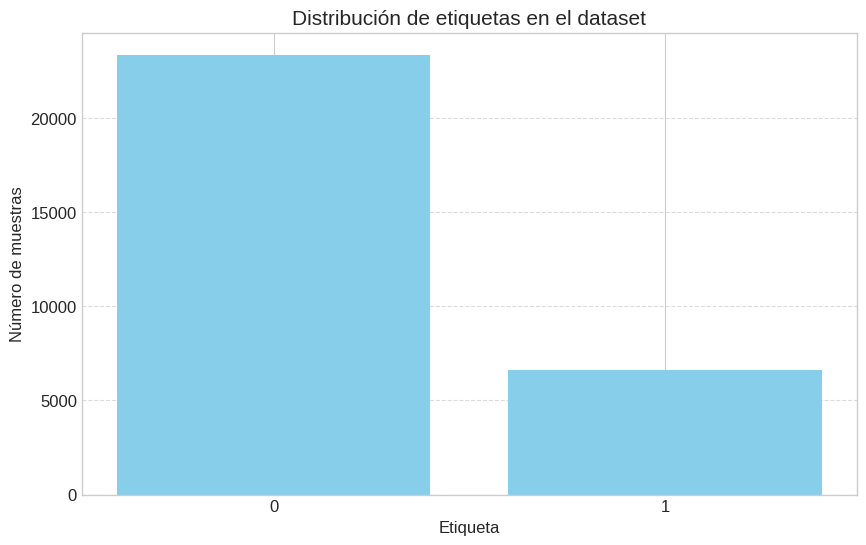

In [6]:
## Bloque 3: Explorar las etiquetas
if X is not None and y is not None:
    unique_labels, counts = np.unique(y, return_counts=True)
    print("\nDistribución de etiquetas originales:")
    for label, count in zip(unique_labels, counts):
        print(f"  Etiqueta {label}: {count} ({count/len(y)*100:.2f}%)")

    # Visualizar distribución
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.title('Distribución de etiquetas en el dataset', fontsize=15)
    plt.xlabel('Etiqueta', fontsize=12)
    plt.ylabel('Número de muestras', fontsize=12)
    plt.xticks(unique_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Realizando PCA para reducir dimensionalidad a 3 componentes...
Varianza explicada: 79.04%
Contribución por componente:
  PC1: 55.29%
  PC2: 14.36%
  PC3: 9.39%


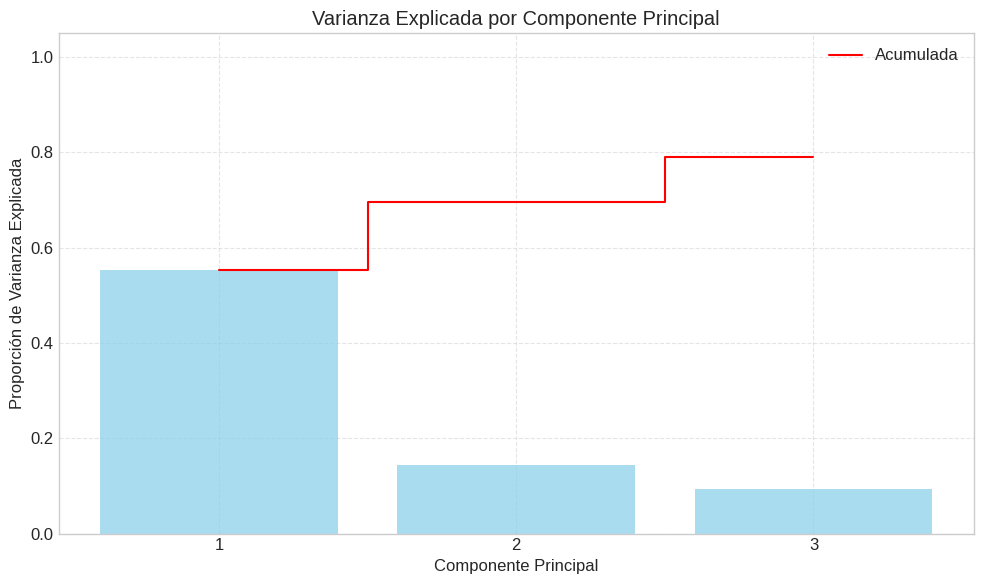

In [7]:
## Bloque 4: Reducción de dimensionalidad con PCA
def perform_pca_analysis(X, n_components=3):
    """Realiza análisis de componentes principales."""
    print(f"Realizando PCA para reducir dimensionalidad a {n_components} componentes...")

    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)

    explained_variance = pca.explained_variance_ratio_
    print(f"Varianza explicada: {explained_variance.sum():.2%}")
    print(f"Contribución por componente:")
    for i, var in enumerate(explained_variance):
        print(f"  PC{i+1}: {var:.2%}")

    # Visualizar varianza explicada
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components+1), explained_variance, alpha=0.7, color='skyblue')
    plt.step(range(1, n_components+1), np.cumsum(explained_variance), where='mid', color='red', label='Acumulada')
    plt.xlabel('Componente Principal')
    plt.ylabel('Proporción de Varianza Explicada')
    plt.title('Varianza Explicada por Componente Principal')
    plt.xticks(range(1, n_components+1))
    plt.ylim([0, 1.05])
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return X_reduced, pca

# Realizar PCA con 3 componentes
if X is not None:
    X_reduced, pca = perform_pca_analysis(X, n_components=3)

In [8]:
## Bloque 5: Funciones para visualización 2D y 3D
def plot_clusters_2d(X_2d, labels=None, centroids=None, title=None, alpha=0.7):
    """Visualiza clusters en 2D con etiquetas y centroides opcionales."""
    plt.figure(figsize=(10, 7))

    # Si no hay etiquetas, usar un solo color
    if labels is None:
        plt.scatter(X_2d[:, 0], X_2d[:, 1], s=30, color='skyblue', alpha=alpha)
    else:
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=30,
                           cmap="Spectral", alpha=alpha)
        plt.colorbar(scatter, label="Cluster")

    # Añadir centroides si están disponibles
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200,
                   linewidths=3, color='black', zorder=10)

    plt.xlabel("Componente Principal 1", fontsize=12)
    plt.ylabel("Componente Principal 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)

    if title:
        plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

def plot_clusters_3d(X_3d, labels=None, centroids=None, elev=30, azim=60, title=None):
    """Visualiza clusters en 3D con etiquetas y centroides opcionales."""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Si no hay etiquetas, usar un solo color
    if labels is None:
        ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], s=30, color='skyblue', alpha=0.7)
    else:
        scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
                          c=labels, s=30, cmap="Spectral", alpha=0.7)
        plt.colorbar(scatter, label="Cluster")

    # Añadir centroides si están disponibles
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                 marker='x', s=200, linewidths=3, color='black', zorder=10)

    ax.set_xlabel("Componente 1", fontsize=12)
    ax.set_ylabel("Componente 2", fontsize=12)
    ax.set_zlabel("Componente 3", fontsize=12)
    ax.view_init(elev=elev, azim=azim)

    if title:
        plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

Visualización de datos originales en espacio PCA 2D:


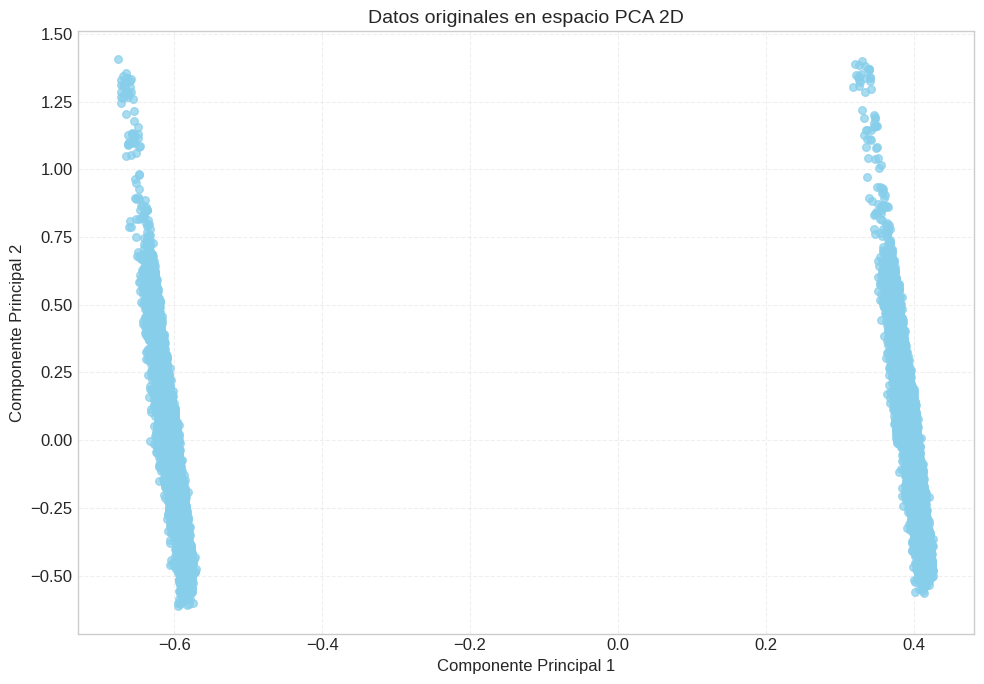


Visualización de datos originales en espacio PCA 3D:


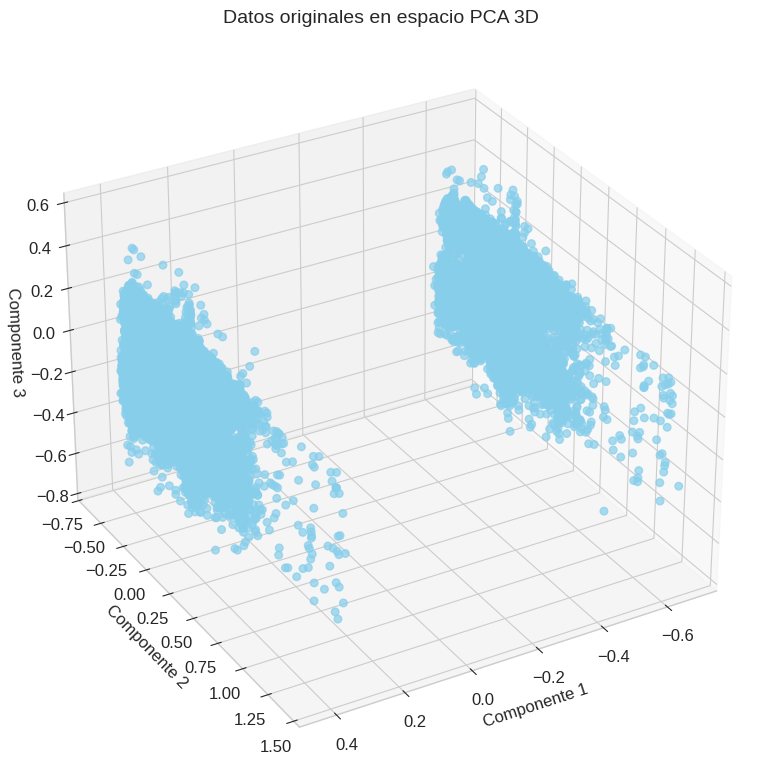

In [9]:
## Bloque 6: Visualización de datos con PCA
# Visualizar datos originales en espacio PCA 2D
if 'X_reduced' in locals():
    print("Visualización de datos originales en espacio PCA 2D:")
    plot_clusters_2d(X_reduced[:, :2], title="Datos originales en espacio PCA 2D")

    # Visualizar datos originales en espacio PCA 3D
    print("\nVisualización de datos originales en espacio PCA 3D:")
    plot_clusters_3d(X_reduced, title="Datos originales en espacio PCA 3D")

In [16]:
## Bloque 7: Función para análisis de K-means
def fit_kmeans(k, X, random_state=42, n_init=10):
    """Ajusta un modelo K-means para un valor k específico."""
    print(f"Entrenando modelo con k={k}...")
    t0 = time.time()

    # Configurar y entrenar modelo KMeans
    kmeans = KMeans(
        n_clusters=k,
        random_state=random_state,
        n_init=n_init,
        algorithm='elkan',  # Algoritmo más rápido en la mayoría de casos
        max_iter=300
    )

    # Ajustar el modelo
    kmeans.fit(X)
    t1 = time.time()

    # Calcular puntuación de silueta
    silhouette = silhouette_score(X, kmeans.labels_)

    # Calcular inercia (suma de distancias cuadradas al centroide)
    inertia = kmeans.inertia_

    print(f"k={k}: Silueta={silhouette:.4f}, Inercia={inertia:.2f}, Tiempo={t1-t0:.2f}s")

    return kmeans, silhouette, inertia

Evaluando modelos para k en [2, 3, 4, 5, 6, 7, 8, 9]...
Entrenando modelo con k=2...
k=2: Silueta=0.5028, Inercia=5824.79, Tiempo=0.23s
Entrenando modelo con k=3...
k=3: Silueta=0.3049, Inercia=5137.93, Tiempo=0.65s
Entrenando modelo con k=4...
k=4: Silueta=0.1854, Inercia=4702.19, Tiempo=0.94s
Entrenando modelo con k=5...
k=5: Silueta=0.1954, Inercia=4285.09, Tiempo=1.68s
Entrenando modelo con k=6...
k=6: Silueta=0.2107, Inercia=3976.06, Tiempo=1.99s
Entrenando modelo con k=7...
k=7: Silueta=0.2045, Inercia=3770.48, Tiempo=1.31s
Entrenando modelo con k=8...
k=8: Silueta=0.2066, Inercia=3579.13, Tiempo=1.31s
Entrenando modelo con k=9...
k=9: Silueta=0.2054, Inercia=3417.08, Tiempo=1.41s


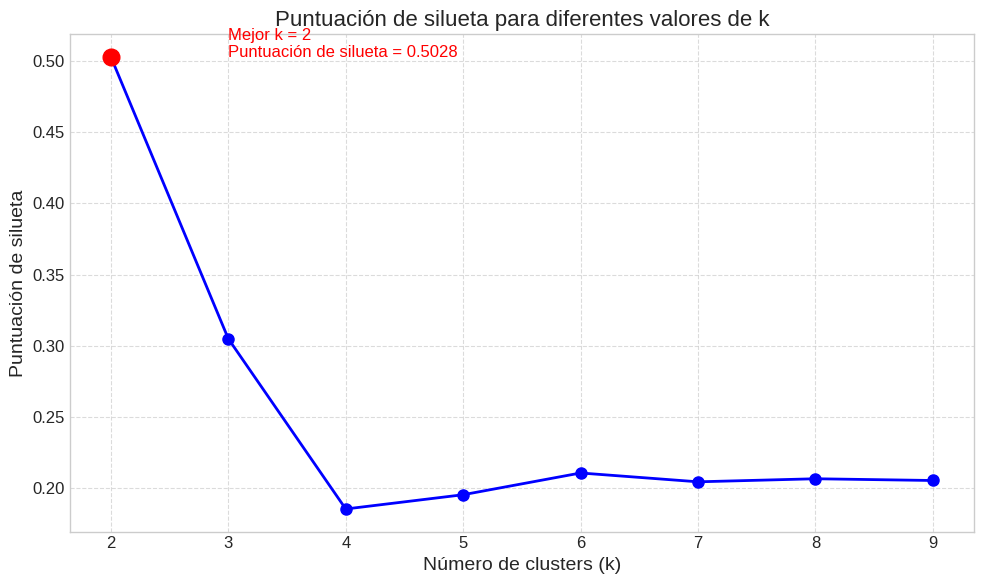

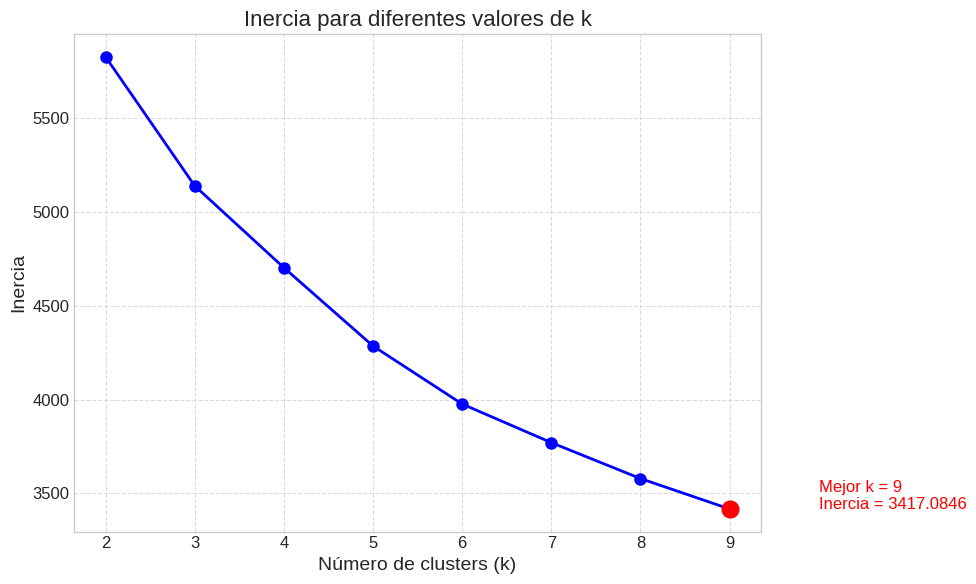


Mejor valor de k según análisis de silueta: 2
Mejor valor de k según método del codo: 9


In [17]:
## Bloque 8: Evaluación de múltiples valores de k
def plot_metrics(k_range, scores, metric_name="Puntuación", method_name="métrica"):
    """Visualiza métricas para diferentes valores de k."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, scores, "bo-", linewidth=2, markersize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel("Número de clusters (k)", fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title(f"{metric_name} para diferentes valores de k", fontsize=16)

    # Identificar el mejor k
    if metric_name == "Puntuación de silueta":
        best_k_idx = np.argmax(scores)
        best_score = max(scores)
    else:  # Inercia
        # Para inercia usamos el método del codo
        best_k_idx = np.argmin(scores)
        best_score = min(scores)

    best_k = k_range[best_k_idx]

    # Marcar el mejor k
    plt.plot(best_k, scores[best_k_idx], 'ro', markersize=12)
    plt.annotate(f'Mejor k = {best_k}\n{metric_name} = {best_score:.4f}',
                xy=(best_k, scores[best_k_idx]),
                xytext=(best_k + 1, scores[best_k_idx]),
                fontsize=12, color='red')

    plt.xticks(k_range)
    plt.tight_layout()
    plt.show()

    return best_k

# Evaluar múltiples valores de k
def find_optimal_k(X, k_range=range(2, 10)):
    """Encuentra el valor óptimo de k."""
    print(f"Evaluando modelos para k en {list(k_range)}...")

    silhouette_scores = []
    inertias = []
    models = {}
    kmeans_per_k = []  # Lista para almacenar los modelos KMeans para cada k

    # Evaluar cada valor de k
    for k in k_range:
        # Entrenar modelo y obtener métricas
        kmeans_model, silhouette, inertia = fit_kmeans(k, X)

        # Guardar resultados
        silhouette_scores.append(silhouette)
        inertias.append(inertia)
        models[k] = kmeans_model
        kmeans_per_k.append(kmeans_model)  # Almacenar modelo en la lista

    # Encontrar el mejor k según silueta
    best_k_silhouette = plot_metrics(k_range, silhouette_scores,
                                  "Puntuación de silueta", "silueta")

    # Evaluar método del codo (inercia)
    best_k_inertia = plot_metrics(k_range, inertias, "Inercia", "codo")

    print(f"\nMejor valor de k según análisis de silueta: {best_k_silhouette}")
    print(f"Mejor valor de k según método del codo: {best_k_inertia}")

    # Nos quedamos con el mejor según silueta
    best_k = best_k_silhouette
    best_model = models[best_k]

    return best_k, best_model, models, silhouette_scores, kmeans_per_k

# Definir rango de k a evaluar
k_range = range(2, 10)  # Evaluamos de 2 a 10 clusters

# Encontrar k óptimo
if 'X' in locals():
    best_k, best_model, models, silhouette_scores, kmeans_per_k = find_optimal_k(X, k_range)


In [18]:
## Bloque 9: Función para análisis de silueta
def plot_silhouette_analysis(X, kmeans, n_clusters):
    """Genera un gráfico detallado del análisis de silueta."""
    print(f"Calculando coeficientes de silueta para k={n_clusters}...")

    # Calcular coeficientes de silueta para cada muestra
    silhouette_vals = silhouette_samples(X, kmeans.labels_)

    # Crear gráfico
    plt.figure(figsize=(12, 8))
    y_lower = 10

    # Generar colores para cada cluster
    colors = plt.cm.get_cmap('Spectral')(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        # Agregar muestras de silueta para el cluster i
        cluster_vals = silhouette_vals[kmeans.labels_ == i]
        cluster_vals.sort()

        size_cluster = cluster_vals.shape[0]
        y_upper = y_lower + size_cluster

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals,
                         facecolor=colors[i], edgecolor='none', alpha=0.7)

        # Etiquetar clusters
        plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
        y_lower = y_upper + 10

    # Puntuación promedio de silueta
    avg_score = np.mean(silhouette_vals)
    plt.axvline(x=avg_score, color="red", linestyle="--",
               label=f'Puntuación promedio: {avg_score:.4f}')

    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    plt.title(f"Análisis de silueta para k = {n_clusters}", fontsize=16)
    plt.xlabel("Coeficientes de silueta", fontsize=14)
    plt.ylabel("Cluster", fontsize=14)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    return avg_score


Generando análisis detallado de silueta para k=2...
Calculando coeficientes de silueta para k=2...


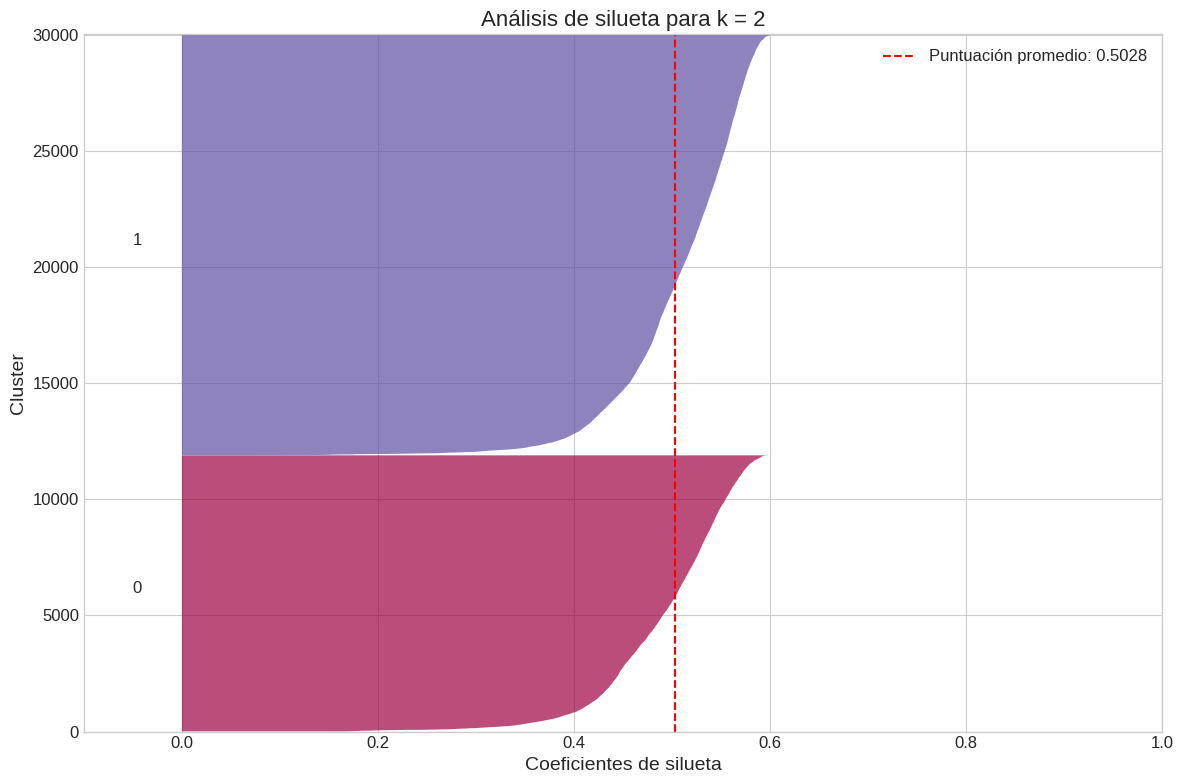


Visualización del mejor clustering en 2D:


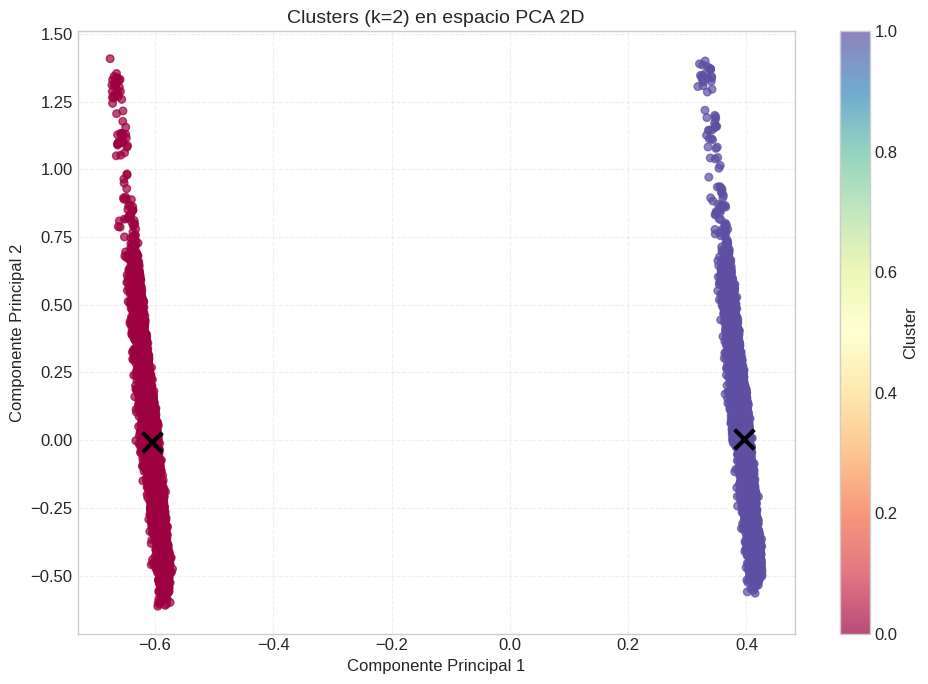

In [19]:
## Bloque 10: Análisis detallado del mejor modelo
# Análisis detallado del mejor modelo
if 'best_model' in locals() and 'X' in locals():
    print(f"\nGenerando análisis detallado de silueta para k={best_k}...")
    plot_silhouette_analysis(X, best_model, best_k)

    # Visualizar en 2D con datos PCA
    if 'X_reduced' in locals() and 'pca' in locals():
        # Proyectar centroides
        centroids_reduced = pca.transform(best_model.cluster_centers_)

        # Visualización 2D
        print("\nVisualización del mejor clustering en 2D:")
        plot_clusters_2d(X_reduced[:, :2], best_model.labels_, centroids_reduced[:, :2],
                       title=f"Clusters (k={best_k}) en espacio PCA 2D")


Visualización del mejor clustering en 3D:


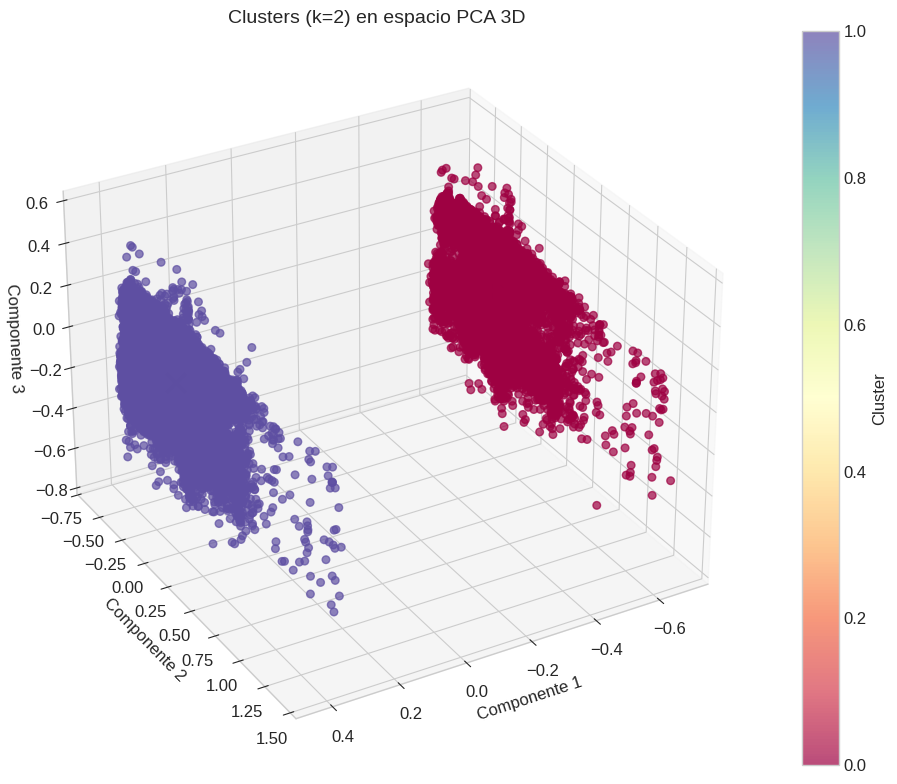


Vista desde diferentes ángulos:


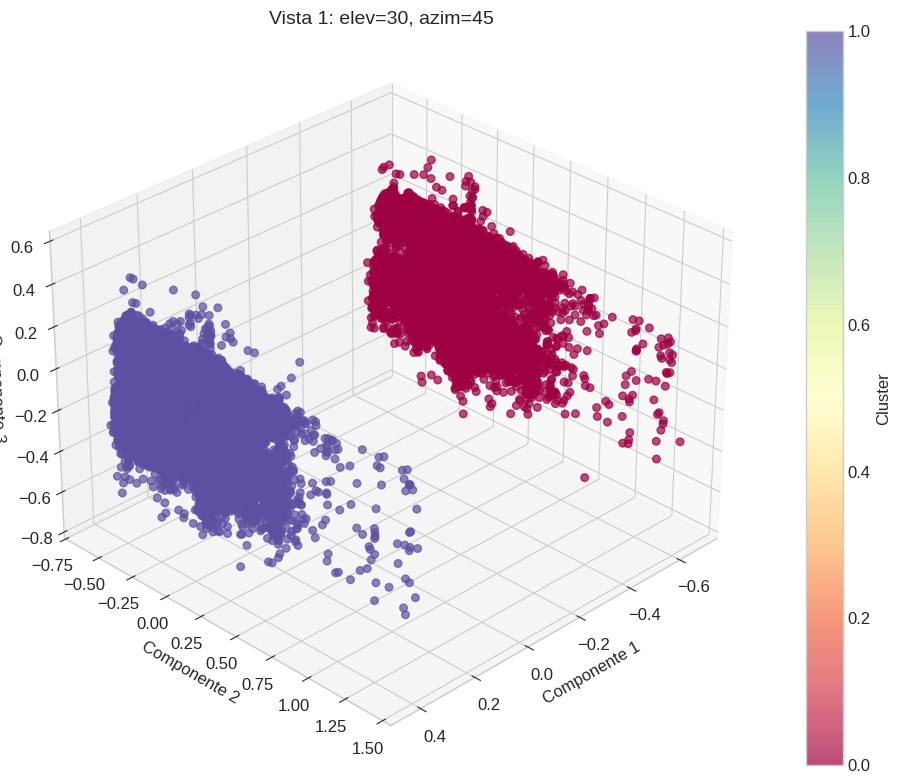

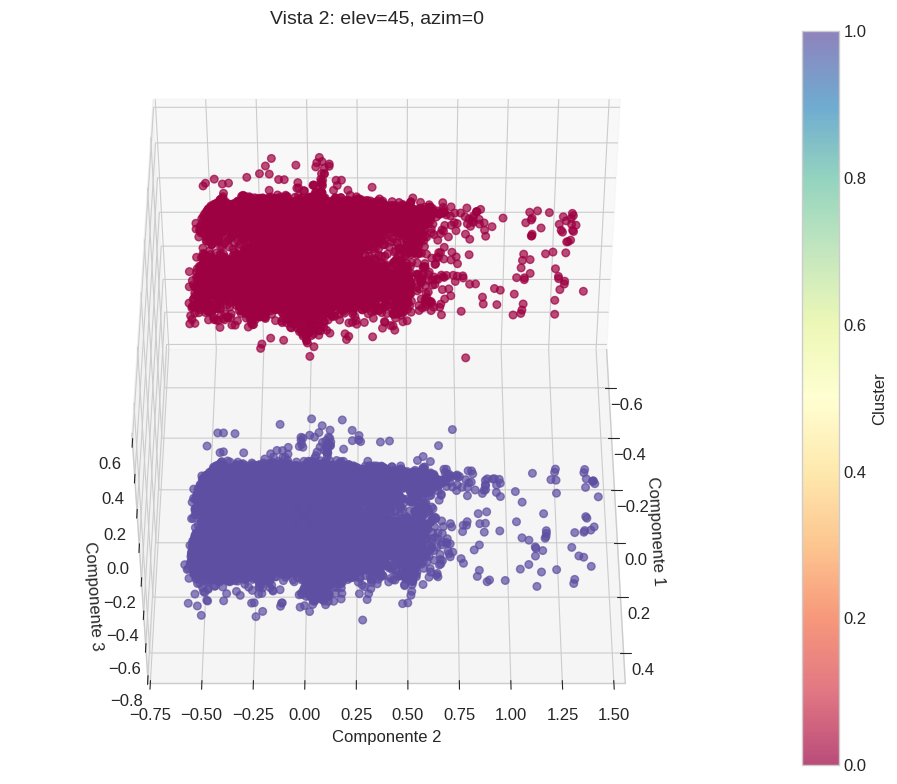

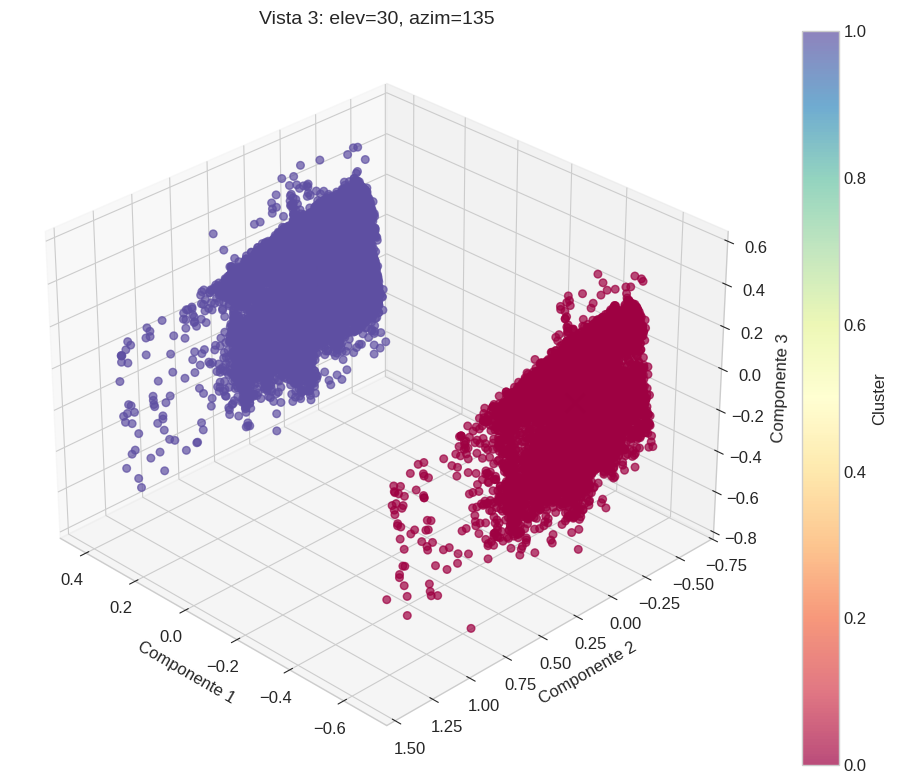

In [20]:
## Bloque 11: Visualización 3D del mejor modelo
# Visualización 3D del mejor modelo
if 'best_model' in locals() and 'X_reduced' in locals() and 'pca' in locals():
    centroids_reduced = pca.transform(best_model.cluster_centers_)
    print("\nVisualización del mejor clustering en 3D:")
    plot_clusters_3d(X_reduced, best_model.labels_, centroids_reduced,
                   title=f"Clusters (k={best_k}) en espacio PCA 3D")

    # Ver desde diferentes ángulos
    print("\nVista desde diferentes ángulos:")
    angles = [(30, 45), (45, 0), (30, 135)]
    for i, (elev, azim) in enumerate(angles):
        plot_clusters_3d(X_reduced, best_model.labels_, centroids_reduced,
                       elev=elev, azim=azim,
                       title=f"Vista {i+1}: elev={elev}, azim={azim}")


Distribución de clusters:
  Cluster 0: 11888 muestras (39.63%)
  Cluster 1: 18112 muestras (60.37%)


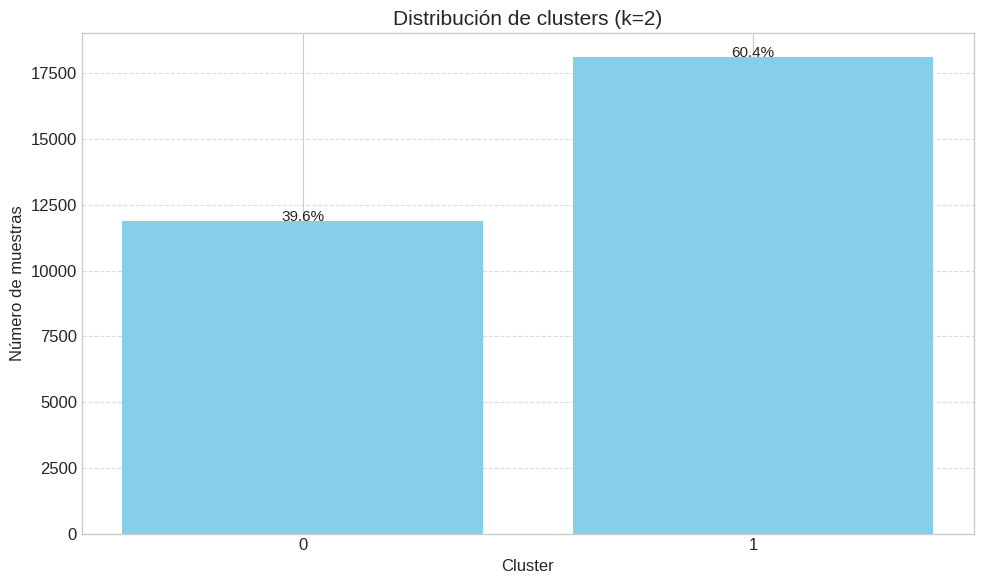


Generando análisis comparativo de siluetas para valores de k (modo: 'all')...
Mostrando gráficos de silueta para todos los valores de k: [2, 3, 4, 5, 6, 7, 8, 9]


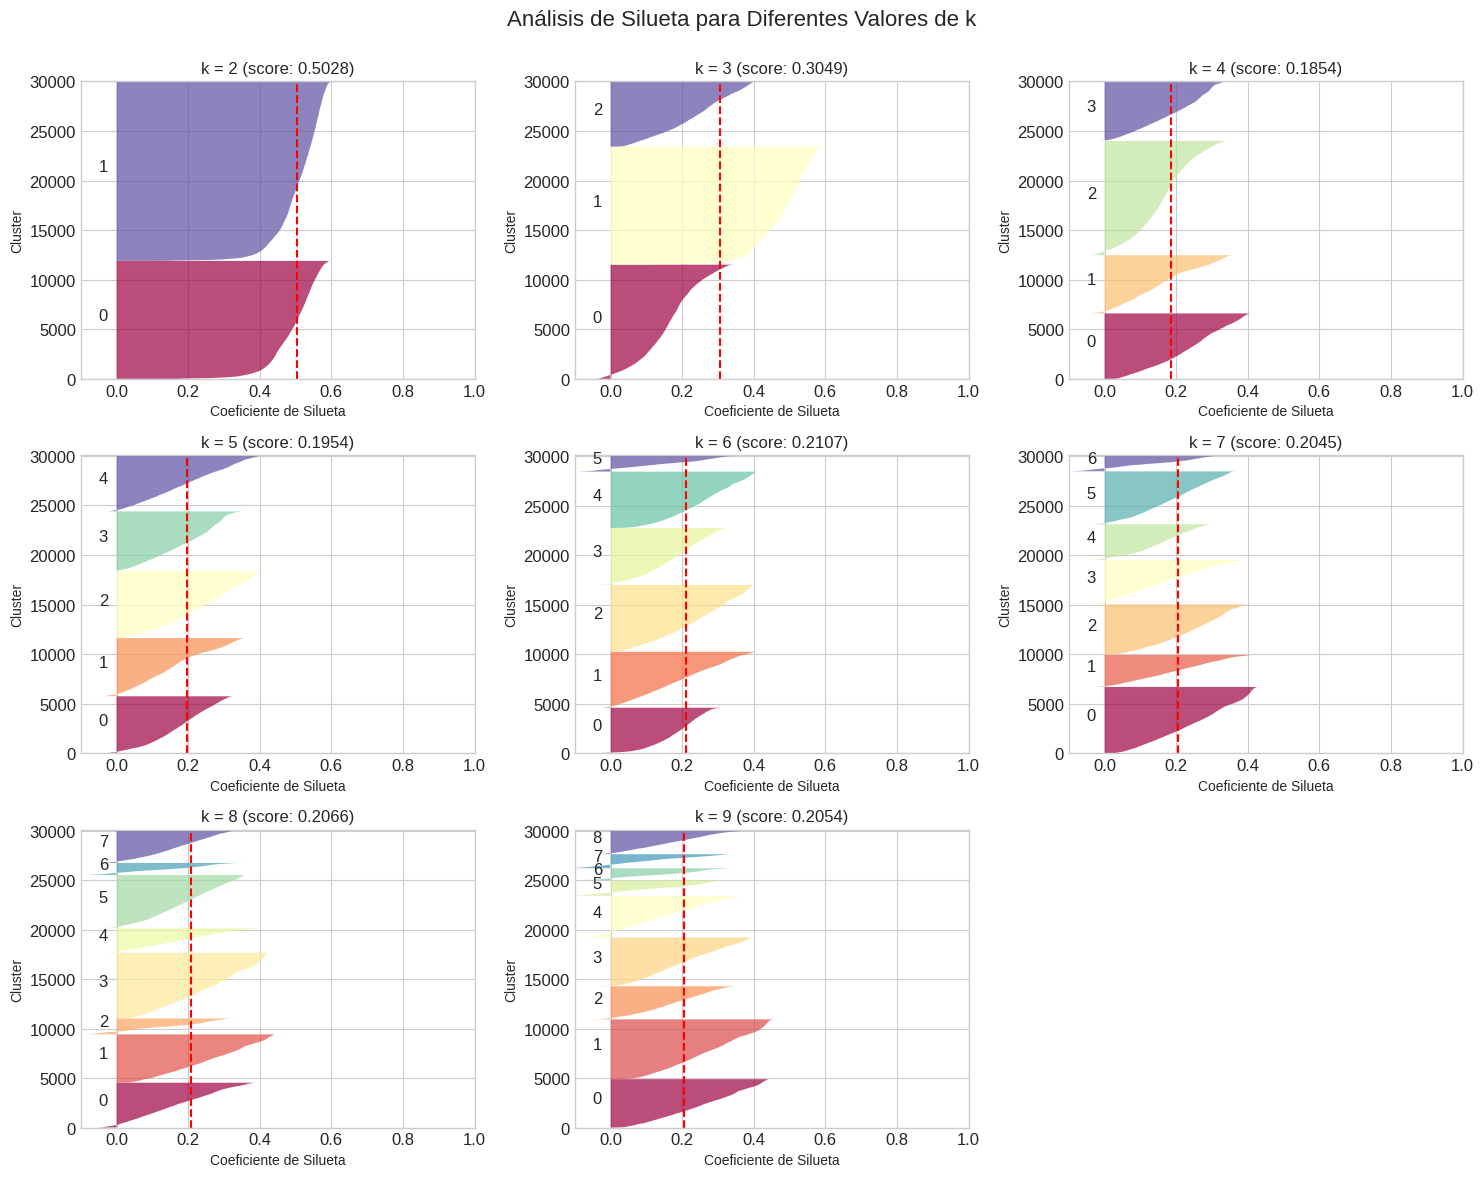

In [21]:
## Bloque 12: Análisis de la distribución de clusters
# Análisis de la distribución de clusters
if 'best_model' in locals() and 'X' in locals():
    print("\nDistribución de clusters:")
    unique_clusters, counts = np.unique(best_model.labels_, return_counts=True)

    for cluster, count in zip(unique_clusters, counts):
        print(f"  Cluster {cluster}: {count} muestras ({count/len(X)*100:.2f}%)")

    # Visualizar distribución de clusters
    plt.figure(figsize=(10, 6))
    plt.bar(unique_clusters, counts, color='skyblue')
    plt.title(f'Distribución de clusters (k={best_k})', fontsize=15)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Número de muestras', fontsize=12)
    plt.xticks(unique_clusters)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Añadir etiquetas con porcentajes
    for i, count in enumerate(counts):
        plt.text(unique_clusters[i], count + 0.1, f'{count/len(X)*100:.1f}%',
                ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()

# Función para visualizar múltiples gráficos de silueta
def plot_multiple_silhouettes(X, k_range, kmeans_per_k, silhouette_scores, mode='best', num_best=4):
    """
    Visualiza gráficos de silueta para múltiples valores de k.

    Parámetros:
    - X: Datos de entrada
    - k_range: Rango de valores k analizados
    - kmeans_per_k: Lista de modelos KMeans entrenados para cada k
    - silhouette_scores: Lista de puntuaciones de silueta para cada k
    - mode: 'best' para mostrar solo los mejores valores de k, 'all' para mostrar todos
    - num_best: Número de mejores valores k a mostrar si mode='best'
    """
    if mode == 'best':
        # Identificamos los mejores valores de k según puntuación de silueta
        best_k_indices = np.argsort(silhouette_scores)[-num_best:]  # Ordenamos e identificamos los mejores
        best_k_indices = sorted(best_k_indices)  # Los ordenamos de menor a mayor k
        k_to_show = [k_range[idx] for idx in best_k_indices]  # Obtenemos los valores de k
        print(f"Mostrando gráficos de silueta para los {num_best} mejores valores de k: {k_to_show}")
    else:  # mode == 'all'
        k_to_show = list(k_range)
        print(f"Mostrando gráficos de silueta para todos los valores de k: {k_to_show}")

    # Determinar la disposición de los subplots
    n_plots = len(k_to_show)
    if n_plots <= 4:
        n_rows, n_cols = 2, 2
    elif n_plots <= 6:
        n_rows, n_cols = 2, 3
    elif n_plots <= 9:
        n_rows, n_cols = 3, 3
    else:
        n_rows, n_cols = (n_plots + 3) // 4, 4  # Aproximación para distribuir los plots

    # Creamos una cuadrícula de subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Convertir a lista para manejar el caso de un solo subplot

    for i, k in enumerate(k_to_show):
        if i < len(axes):
            ax = axes[i]

            # Obtenemos el modelo KMeans para este valor de k
            k_idx = list(k_range).index(k)  # Índice en la lista kmeans_per_k
            kmeans = kmeans_per_k[k_idx]

            # Calculamos los valores de silueta para este modelo
            silhouette_vals = silhouette_samples(X, kmeans.labels_)

            # Rango del gráfico de silueta
            ax.set_xlim([-0.1, 1])

            # Altura para el gráfico (ajustamos dinámicamente)
            y_lower = 10

            # Colores para los clusters
            colors = plt.cm.get_cmap('Spectral')(np.linspace(0, 1, k))

            # Promedio global de silueta para este k
            avg_score = np.mean(silhouette_vals)

            for j in range(k):
                # Valores de silueta para el cluster j
                ith_cluster_values = silhouette_vals[kmeans.labels_ == j]
                ith_cluster_values.sort()

                size_cluster = ith_cluster_values.shape[0]
                y_upper = y_lower + size_cluster

                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                0, ith_cluster_values,
                                facecolor=colors[j], edgecolor='none', alpha=0.7)

                # Etiquetamos los clusters
                ax.text(-0.05, y_lower + 0.5 * size_cluster, str(j))

                y_lower = y_upper + 10

            # Añadimos la línea de promedio
            ax.axvline(x=avg_score, color="r", linestyle="--")

            # Configuramos el título y etiquetas
            score = silhouette_scores[k_idx]
            ax.set_title(f"k = {k} (score: {score:.4f})", fontsize=12)
            ax.set_xlabel("Coeficiente de Silueta", fontsize=10)
            ax.set_ylabel("Cluster", fontsize=10)

            # Ajustamos para que se vean los valores del eje y
            max_y = y_lower
            ax.set_ylim([0, max_y])

    # Ocultar ejes extras si hay más subplots que valores de k
    for i in range(len(k_to_show), len(axes)):
        axes[i].set_visible(False)

    plt.suptitle("Análisis de Silueta para Diferentes Valores de k", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Llamada a la función de visualización de múltiples siluetas
if 'X' in locals() and 'kmeans_per_k' in locals() and 'silhouette_scores' in locals():
    print(f"\nGenerando análisis comparativo de siluetas para valores de k (modo: 'all')...")
    plot_multiple_silhouettes(X, k_range, kmeans_per_k, silhouette_scores, mode='all')

In [22]:
## Bloque 13: Preparación para aprendizaje semisupervisado
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import time

# Separación de datos en conjuntos de entrenamiento y prueba
test_size = 0.3  # 30% para prueba, 70% para entrenamiento
random_state_split = 42  # Para reproducibilidad

if 'X' in locals() and 'y' in locals():
    try:
        # Separar los datos en entrenamiento y prueba
        # Convertir a array numpy si no lo es ya
        X_array = np.array(X)
        y_array = np.array(y)

        # Verificar si las etiquetas son cadenas de texto
        if y_array.dtype.kind in ['U', 'S', 'O']:  # U: Unicode, S: String, O: Object
            print("Detectadas etiquetas de texto. Convirtiendo a valores numéricos...")
            # Convertir etiquetas de texto a números
            unique_labels = np.unique(y_array)
            label_to_num = {label: i for i, label in enumerate(unique_labels)}
            y_numeric = np.array([label_to_num[label] for label in y_array])

            # Guardar la conversión para referencia
            for label, num in label_to_num.items():
                print(f"  - Etiqueta '{label}' → {num}")

            # Usar las etiquetas numéricas para stratify
            y_stratify = y_numeric

            # Mantener las etiquetas originales para el entrenamiento
            # pero asegurarse de conocer la conversión
            y_array_original = y_array.copy()
            y_array = y_numeric
        else:
            y_stratify = y_array
            y_array_original = None

        # Verificar que hay suficientes muestras
        unique_classes, class_counts = np.unique(y_array, return_counts=True)
        min_samples = min(class_counts)

        if min_samples >= 2:  # Necesitamos al menos 2 muestras por clase para stratify
            X_train, X_test, y_train, y_test = train_test_split(
                X_array, y_array, test_size=test_size, random_state=random_state_split, stratify=y_stratify
            )
        else:
            print(f"Advertencia: Algunas clases tienen muy pocas muestras (mínimo: {min_samples}). Omitiendo stratify.")
            X_train, X_test, y_train, y_test = train_test_split(
                X_array, y_array, test_size=test_size, random_state=random_state_split
            )

        print(f"\nDatos divididos en:")
        print(f"  - Entrenamiento: {X_train.shape[0]} muestras")
        print(f"  - Prueba: {X_test.shape[0]} muestras")

        # Si teníamos etiquetas originales, conservarlas también
        if y_array_original is not None:
            _, _, y_train_original, y_test_original = train_test_split(
                X_array, y_array_original, test_size=test_size, random_state=random_state_split, stratify=y_stratify
            )
            print("Se mantienen las etiquetas originales y numéricas para referencia.")
    except Exception as e:
        print(f"Error al dividir los datos: {e}")
        X_train, X_test, y_train, y_test = None, None, None, None
else:
    print("Error: Los datos (X) o las etiquetas (y) no están disponibles para realizar la separación.")


Datos divididos en:
  - Entrenamiento: 21000 muestras
  - Prueba: 9000 muestras


In [23]:
## Bloque 14: Aplicación de K-Means para aprendizaje semisupervisado

# Definir el número de clusters para K-Means, con una validación de no exceder el tamaño de los datos
if 'X_train' in locals() and X_train is not None:
    # Asegurarse de que n_clusters_semi no sea mayor que el número de muestras
    n_clusters_semi = min(20, X_train.shape[0] // 10)  # Máximo 20 o 1/10 del tamaño de los datos
    n_clusters_semi = max(2, n_clusters_semi)  # Asegurar al menos 2 clusters

    print(f"\nAplicando K-Means con {n_clusters_semi} clusters al conjunto de entrenamiento...")

    try:
        # Entrenar el modelo K-Means solo en el conjunto de entrenamiento
        kmeans_semi = KMeans(n_clusters=n_clusters_semi, random_state=42, n_init=10)
        kmeans_semi.fit(X_train)
        print("Modelo K-Means entrenado en el conjunto de entrenamiento.")

        # Encontrar las muestras más cercanas a los centroides en el conjunto de entrenamiento
        X_clusters_dist_train = kmeans_semi.transform(X_train)
        # Para cada cluster, encontrar la muestra más cercana al centroide
        representative_idxs_train = []
        for i in range(n_clusters_semi):
            # Filtrar solo las muestras asignadas a este cluster
            cluster_samples = np.where(kmeans_semi.labels_ == i)[0]
            if len(cluster_samples) > 0:
                # Entre estas muestras, encontrar la más cercana al centroide
                distances_to_centroid = X_clusters_dist_train[cluster_samples, i]
                closest_sample_idx = cluster_samples[np.argmin(distances_to_centroid)]
                representative_idxs_train.append(closest_sample_idx)
            else:
                print(f"Advertencia: El cluster {i} está vacío.")

        # Convertir a array numpy si no lo es ya
        representative_idxs_train = np.array(representative_idxs_train)

        # Obtener las muestras representativas
        X_representative_samples_train = X_train[representative_idxs_train]
        print(f"Identificadas {len(representative_idxs_train)} muestras representativas en el conjunto de entrenamiento.")
    except Exception as e:
        print(f"Error al aplicar K-Means: {e}")
        kmeans_semi, representative_idxs_train, X_representative_samples_train = None, None, None
else:
    print("Error: El conjunto de entrenamiento no está disponible.")


Aplicando K-Means con 20 clusters al conjunto de entrenamiento...
Modelo K-Means entrenado en el conjunto de entrenamiento.
Identificadas 20 muestras representativas en el conjunto de entrenamiento.


In [24]:
## Bloque 15: Simulación del etiquetado de muestras representativas

if ('y_train' in locals() and y_train is not None and
    'representative_idxs_train' in locals() and representative_idxs_train is not None):
    try:
        # Verificar que los índices estén dentro de los límites
        max_idx = len(y_train) - 1
        valid_indices = [idx for idx in representative_idxs_train if 0 <= idx <= max_idx]

        if len(valid_indices) != len(representative_idxs_train):
            print(f"Advertencia: Se eliminaron {len(representative_idxs_train) - len(valid_indices)} índices inválidos.")
            representative_idxs_train = np.array(valid_indices)

        # Simular el etiquetado de las muestras representativas usando las etiquetas reales
        y_representative_samples_train = y_train[representative_idxs_train]
        print("Etiquetas simuladas para las muestras representativas del conjunto de entrenamiento.")

        # Si tenemos las etiquetas originales, usarlas para mostrar la distribución
        if 'y_train_original' in locals() and y_train_original is not None:
            y_representative_samples_original = y_train_original[representative_idxs_train]
            unique_labels_rep, counts_rep = np.unique(y_representative_samples_original, return_counts=True)
            print("\nDistribución de etiquetas originales en muestras representativas:")
            for label, count in zip(unique_labels_rep, counts_rep):
                print(f"  Etiqueta '{label}': {count} muestras ({count/len(y_representative_samples_original)*100:.2f}%)")

            # También guardar las etiquetas numéricas para visualización
            y_representative_samples_train_numeric = y_representative_samples_train
        else:
            # Mostrar la distribución de etiquetas numéricas en las muestras representativas
            unique_labels_rep, counts_rep = np.unique(y_representative_samples_train, return_counts=True)
            print("\nDistribución de etiquetas en muestras representativas:")
            for label, count in zip(unique_labels_rep, counts_rep):
                print(f"  Etiqueta {label}: {count} muestras ({count/len(y_representative_samples_train)*100:.2f}%)")

            # Las etiquetas ya son numéricas
            y_representative_samples_train_numeric = y_representative_samples_train
    except Exception as e:
        print(f"Error al simular etiquetado: {e}")
        y_representative_samples_train = None
else:
    print("Error: Las etiquetas del conjunto de entrenamiento no están disponibles.")

Etiquetas simuladas para las muestras representativas del conjunto de entrenamiento.

Distribución de etiquetas en muestras representativas:
  Etiqueta 0: 17 muestras (85.00%)
  Etiqueta 1: 3 muestras (15.00%)


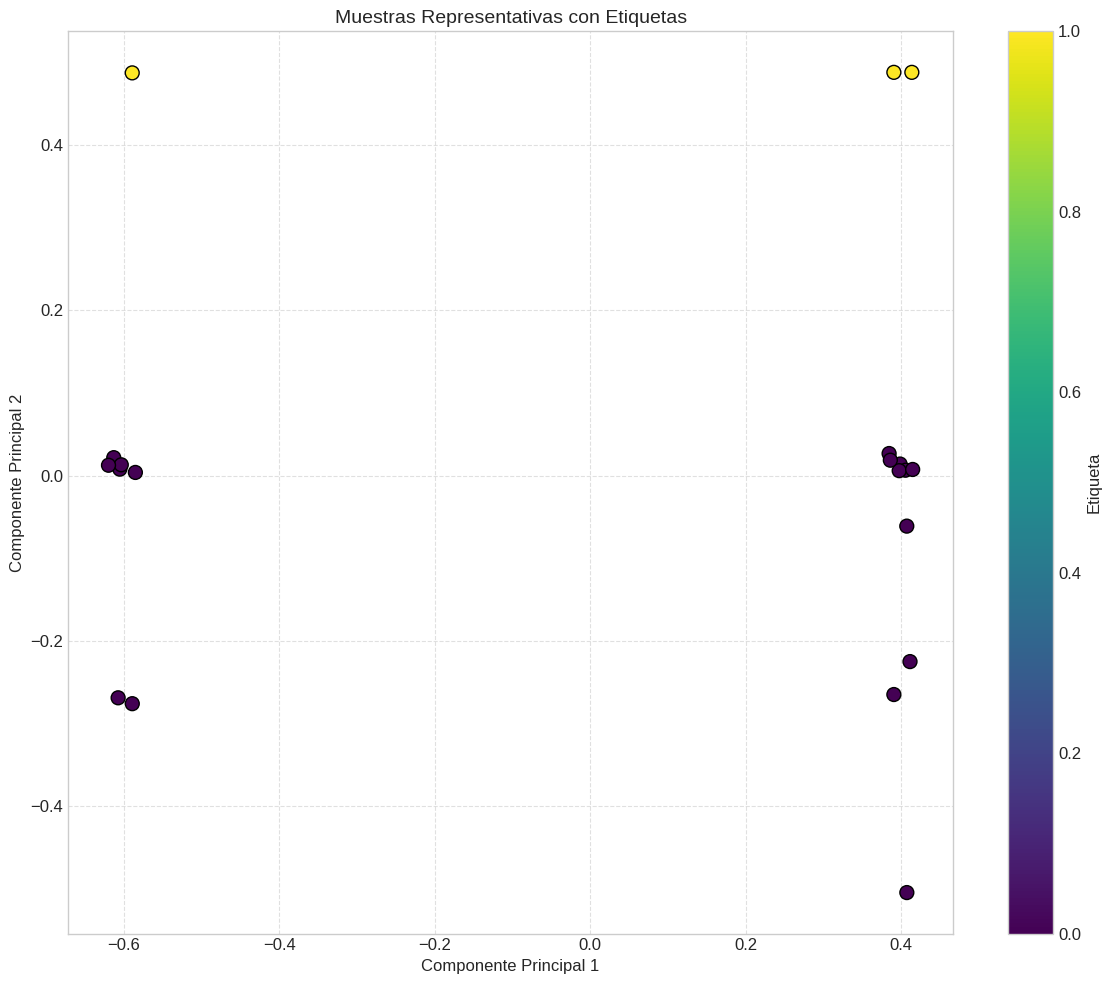

In [25]:
## Bloque 16: Visualización de las muestras representativas

if ('X_representative_samples_train' in locals() and X_representative_samples_train is not None and
    'y_representative_samples_train' in locals() and y_representative_samples_train is not None):
    try:
        # Reducir dimensionalidad de las muestras representativas para visualización
        if X_representative_samples_train.shape[1] > 2:
            pca_vis = PCA(n_components=2, random_state=42)
            X_representative_reduced = pca_vis.fit_transform(X_representative_samples_train)
        else:
            X_representative_reduced = X_representative_samples_train

        # Asegurarse de que las etiquetas sean numéricas para colorear el scatter plot
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(X_representative_reduced[:, 0], X_representative_reduced[:, 1],
                           c=y_representative_samples_train_numeric, cmap='viridis', s=100, edgecolors='k')
        plt.title('Muestras Representativas con Etiquetas', fontsize=14)
        plt.xlabel('Componente Principal 1', fontsize=12)
        plt.ylabel('Componente Principal 2', fontsize=12)
        plt.colorbar(scatter, label='Etiqueta')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Verificar si el dataset podría ser de imágenes basado en dimensiones
        feature_count = X_train.shape[1]
        if feature_count in [784, 1024, 3072]:  # Tamaños comunes para imágenes
            print("El conjunto de datos parece contener imágenes, intentando visualizarlas...")
            # Determinar tamaño de imagen según número de características
            if feature_count == 784:  # MNIST (28x28)
                image_dim = (28, 28)
            elif feature_count == 1024:  # 32x32 escala de grises
                image_dim = (32, 32)
            elif feature_count == 3072:  # CIFAR (32x32x3)
                image_dim = (32, 32, 3)
            else:
                image_dim = None

            # Si las dimensiones no coinciden con formatos comunes, intentar detectarlas
            if image_dim is None:
                # Intentar encontrar dimensiones cuadradas
                side_length = int(np.sqrt(feature_count))
                if side_length**2 == feature_count:  # Es un cuadrado perfecto
                    image_dim = (side_length, side_length)
                    print(f"Detectadas dimensiones de imagen: {image_dim}")
                elif feature_count % 3 == 0:  # Posible imagen RGB
                    side_length = int(np.sqrt(feature_count / 3))
                    if (side_length**2) * 3 == feature_count:
                        image_dim = (side_length, side_length, 3)
                        print(f"Detectadas dimensiones de imagen RGB: {image_dim}")
                else:
                    print("No se pudieron detectar dimensiones de imagen válidas.")

            if image_dim:
                try:
                    # Determinar número de filas y columnas para visualización
                    n_images = len(X_representative_samples_train)
                    cols = min(5, n_images)
                    rows = (n_images + cols - 1) // cols

                    plt.figure(figsize=(15, 3*rows))

                    # Obtener etiquetas para mostrar en los títulos
                    if 'y_representative_samples_original' in locals() and y_representative_samples_original is not None:
                        labels_to_show = y_representative_samples_original
                    else:
                        labels_to_show = y_representative_samples_train

                    for i, (img, label) in enumerate(zip(X_representative_samples_train, labels_to_show)):
                        plt.subplot(rows, cols, i+1)

                        # Rehacemos la imagen según sus dimensiones
                        if len(image_dim) == 3:  # Imagen a color
                            # Verificar y normalizar si es necesario
                            if img.max() > 1.0:
                                img_normalized = img / 255.0
                            else:
                                img_normalized = img
                            plt.imshow(img_normalized.reshape(image_dim))
                        else:  # Imagen en escala de grises
                            plt.imshow(img.reshape(image_dim), cmap='gray')

                        plt.title(f"Cluster {i}: {label}", fontsize=10)
                        plt.axis('off')

                    plt.suptitle('Muestras Representativas de Cada Cluster', fontsize=16)
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.9)
                    plt.show()
                except Exception as e:
                    print(f"Error al visualizar imágenes: {e}")
                    print("Intentando un método alternativo de visualización...")

                    # Método alternativo sin usar reshape
                    plt.figure(figsize=(15, 3*rows))
                    for i, (img, label) in enumerate(zip(X_representative_samples_train, labels_to_show)):
                        plt.subplot(rows, cols, i+1)
                        plt.title(f"Cluster {i}: {label}", fontsize=10)
                        plt.axis('off')

                        # Visualizar como mapa de calor sin intentar remodelar
                        plt.imshow(img.reshape(-1, 1), aspect='auto', cmap='viridis')

                    plt.suptitle('Visualización alternativa - Muestras representativas', fontsize=16)
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.9)
                    plt.show()
    except Exception as e:
        print(f"Error en la visualización: {e}")
        # Mostrar más detalles sobre el error
        import traceback
        traceback.print_exc()
else:
    print("Error: Las muestras representativas no están disponibles para visualización.")

In [26]:
## Bloque 17: Propagación de etiquetas para aprendizaje semisupervisado

if ('X_train' in locals() and X_train is not None and
    'kmeans_semi' in locals() and kmeans_semi is not None and
    'y_representative_samples_train' in locals() and y_representative_samples_train is not None):
    try:
        # Obtener asignaciones de clusters para conjunto de entrenamiento
        train_cluster_labels = kmeans_semi.labels_

        # Verificar que todas las etiquetas representativas están disponibles
        n_effective_clusters = len(y_representative_samples_train)

        # Propagar etiquetas desde las muestras representativas a todo el conjunto de entrenamiento
        y_pseudo_labels_train = np.zeros_like(y_train)

        # Iterar por cada cluster y propagar su etiqueta
        for i in range(n_effective_clusters):
            # Verificar si el índice está dentro del rango
            if i < len(y_representative_samples_train):
                # Índices de muestras en el cluster i
                cluster_i_indices = np.where(train_cluster_labels == i)[0]
                if len(cluster_i_indices) > 0:  # Solo si hay muestras en este cluster
                    # Asignar la etiqueta de la muestra representativa a todas las muestras del cluster
                    y_pseudo_labels_train[cluster_i_indices] = y_representative_samples_train[i]

        print(f"Pseudo-etiquetas propagadas a las {len(y_pseudo_labels_train)} muestras del conjunto de entrenamiento.")

        # Evaluar precisión de las pseudo-etiquetas en entrenamiento
        accuracy_train = np.mean(y_pseudo_labels_train == y_train)
        print(f"Precisión de las pseudo-etiquetas en entrenamiento: {accuracy_train:.4f}")
    except Exception as e:
        print(f"Error en la propagación de etiquetas: {e}")
        y_pseudo_labels_train = None
        accuracy_train = None
else:
    print("Error: No se dispone de los datos necesarios para la propagación de etiquetas.")

Pseudo-etiquetas propagadas a las 21000 muestras del conjunto de entrenamiento.
Precisión de las pseudo-etiquetas en entrenamiento: 0.8038


Precisión de las pseudo-etiquetas en conjunto de prueba: 0.8013


<Figure size 1000x800 with 0 Axes>

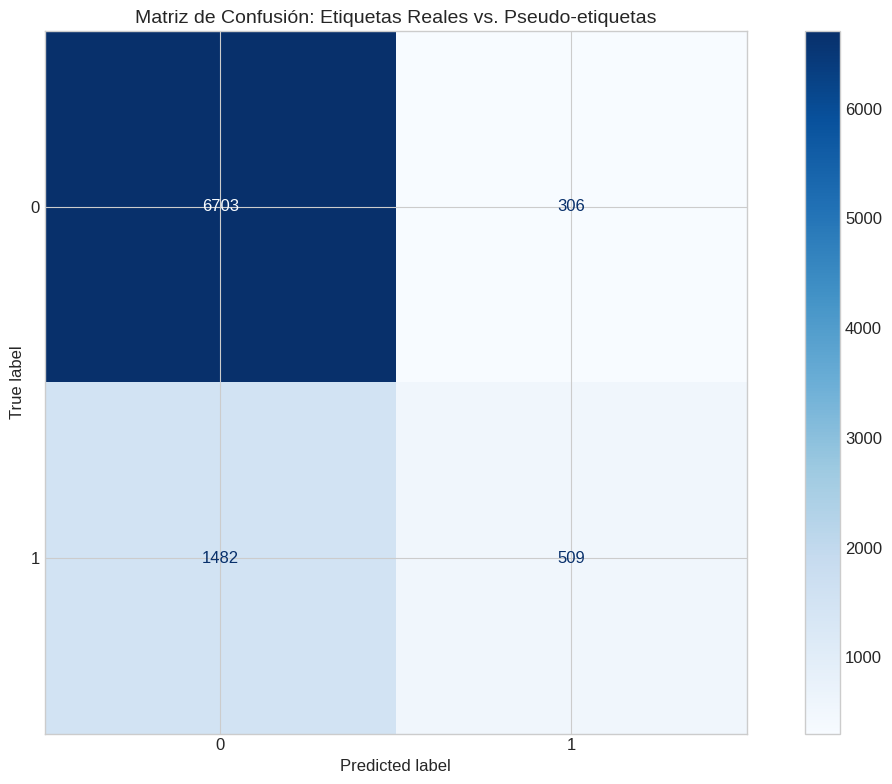

In [27]:
## Bloque 18: Predicción y evaluación en conjunto de prueba

if ('X_test' in locals() and X_test is not None and
    'kmeans_semi' in locals() and kmeans_semi is not None and
    'y_representative_samples_train' in locals() and y_representative_samples_train is not None and
    'y_test' in locals() and y_test is not None):
    try:
        # Predecir clusters para conjunto de prueba
        test_cluster_labels = kmeans_semi.predict(X_test)

        # Verificar número efectivo de clusters y muestras representativas
        n_effective_clusters = len(y_representative_samples_train)

        # Asegurarse de que los índices de clusters no excedan el número de muestras representativas
        test_cluster_labels = np.clip(test_cluster_labels, 0, n_effective_clusters - 1)

        # Asignar pseudo-etiquetas basadas en las muestras representativas
        y_pseudo_labels_test = np.zeros_like(y_test)

        # Iterar por cada cluster
        for i in range(n_effective_clusters):
            # Índices de muestras asignadas al cluster i
            cluster_i_indices = np.where(test_cluster_labels == i)[0]
            if len(cluster_i_indices) > 0:  # Solo si hay muestras en este cluster
                y_pseudo_labels_test[cluster_i_indices] = y_representative_samples_train[i]

        # Evaluar precisión en conjunto de prueba
        accuracy_test = np.mean(y_pseudo_labels_test == y_test)
        print(f"Precisión de las pseudo-etiquetas en conjunto de prueba: {accuracy_test:.4f}")

        # Visualizar matriz de confusión
        try:
            from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y_test, y_pseudo_labels_test)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap=plt.cm.Blues)
            plt.title('Matriz de Confusión: Etiquetas Reales vs. Pseudo-etiquetas', fontsize=14)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al generar matriz de confusión: {e}")
    except Exception as e:
        print(f"Error en la evaluación del conjunto de prueba: {e}")
        accuracy_test = None
else:
    print("Error: No se dispone de los datos necesarios para la evaluación en el conjunto de prueba.")
